In [4]:
!git clone https://github.com/peterjsadowski/pokemon_pca.git # Retrieves data set.

Cloning into 'pokemon_pca'...
remote: Enumerating objects: 820, done.
remote: Counting objects: 100% (820/820), done.
remote: Compressing objects: 100% (819/819), done.
remote: Total 820 (delta 1), reused 820 (delta 1), pack-reused 0
Receiving objects: 100% (820/820), 2.38 MiB | 2.17 MiB/s, done.
Resolving deltas: 100% (1/1), done.


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


(809, 120, 120, 3) (809, 28, 28, 1)


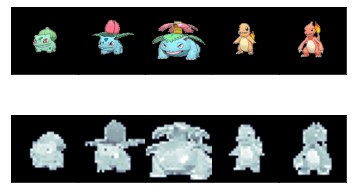

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
from PIL import Image

# Only keep pokemon for which we have images and meta data.
filenames = [f[2] for f in os.walk('./pokemon_pca/data/images/')][0]
pokemon_names = [f.split('/')[-1].split('.')[0] for f in filenames]
df = pd.read_csv('./pokemon_pca/data/pokemon.csv', index_col=0)

# One hot encode the pokemon's primary type
pokemon_types= df['Type1'].unique()
labels_names = df['Type1']
labels_one_hot = pd.get_dummies(labels_names, columns=pokemon_types)
labels_idx = np.argmax(labels_one_hot.to_numpy(), axis=1) # Get label as integer.

# Go through add grab images and save them to list.
imgs = []
gray_imgs = []
for name in df.index:
  filename = glob.glob(f'./pokemon_pca/data/images/{name}.*')[0]
  
  # Open the image with PIL and save it as grayscale color and grayscale but in RGB format
  img = Image.open(filename).convert('RGB') # Some are RGBA so we convert them
  imgs.append(np.array(img))
  # Save a gray scale version,.
  gray_img = np.array(img.convert('L') )
  if gray_img[0,0] == 255:
    gray_img = 255 - gray_img # invert colors. Example 9 had this problem.
  # Crop (weird edge effects on bottom)
  gray_img = gray_img[15:99,15:99]
  # Downsample (makes pca faster).
  input_size = 84
  output_size = 28
  bin_size = input_size // output_size
  gray_img = gray_img.reshape((output_size, bin_size, output_size, bin_size)).max(3).max(1)
  gray_imgs.append(gray_img)

# Convert lists to numpy arrays.
imgs = np.array(imgs)
gray_imgs = np.array(gray_imgs)
gray_imgs = np.expand_dims(gray_imgs, axis=-1)
print(imgs.shape, gray_imgs.shape)

# Show some original images and grayscale downsampled versions.
fig,ax = plt.subplots(2,5, gridspec_kw = {'wspace':0, 'hspace':0}) 
for i in range(0,5,1):
  ax[0,i].imshow(imgs[i,:,:])
  ax[1,i].imshow(gray_imgs[i,:,:,0], cmap=plt.get_cmap('bone'))
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);

Text(0, 0.5, 'Value')

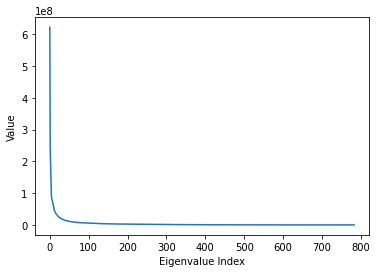

In [7]:
# Define a matrix
X = gray_imgs
N = X.shape[0]
X = X.reshape(N,-1)

# Calculate the mean of each column
mu = np.mean(X, axis=0)
X  = X - mu

# Calculate covariance matrix of centered matrix
C = X.T.dot(X) 

# Eigendecomposition of covariance matrix
eigenvalues, eigenvectors = np.linalg.eig(C)
# The eigenvalues and vectors to be sorted by eigenvalue
a = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[a]
eigenvectors = eigenvectors[a] # Column i is ith eigenvalue.
eigenvectors = np.real(eigenvectors) # Imaginary part should be zero, and we ignore it.
#print(eigenvectors)
#print(eigenvalues)
plt.plot(eigenvalues)
plt.xlabel('Eigenvalue Index')
plt.ylabel('Value')

(809, 2)


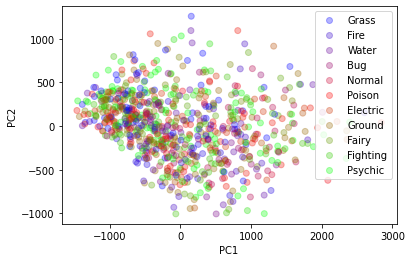

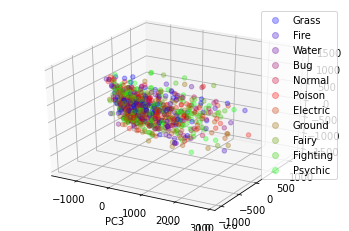

In [8]:
# Project data into first k principal components.
k = 2
P = X.dot(eigenvectors[:,:k])
plt.figure(1)
# Color pokemon by type to see if any clusters emerge.
scatter = plt.scatter(P[:,0], P[:,1], c=labels_idx/labels_idx.max(), cmap='brg', alpha=0.3)
# Create labels for the different colors.
legend1 = plt.legend(scatter.legend_elements()[0], pokemon_types)
plt.xlabel('PC1')
plt.ylabel('PC2')

# 3D Plot
k = 3
P = X.dot(eigenvectors[:,:k])
fig = plt.figure(2)
ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(P[:,0], P[:,1], P[:,2], c=labels_idx/labels_idx.max(), cmap='brg', alpha=0.3)
ax.set_xlabel('PC1')
ax.set_xlabel('PC2')
ax.set_xlabel('PC3')
legend1 = plt.legend(scatter.legend_elements()[0], pokemon_types)

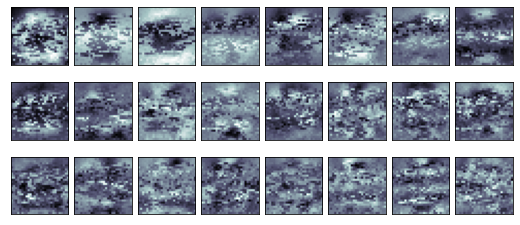

In [10]:
# Visualize principal components.
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
  ax.imshow(eigenvectors[:,i].reshape(output_size, output_size), cmap='bone')

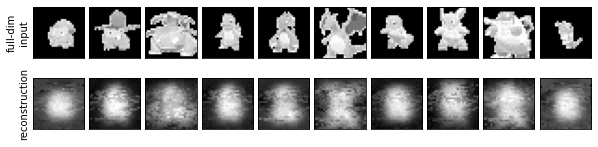

In [13]:
# Plot reconstructions.
k = 10
projected = X.dot(eigenvectors[:,:k]).dot(eigenvectors[:,:k].T) + mu
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(gray_imgs[i].reshape(output_size,output_size), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(output_size,output_size), cmap='binary_r')
    
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('reconstruction');

<Figure size 720x720 with 0 Axes>

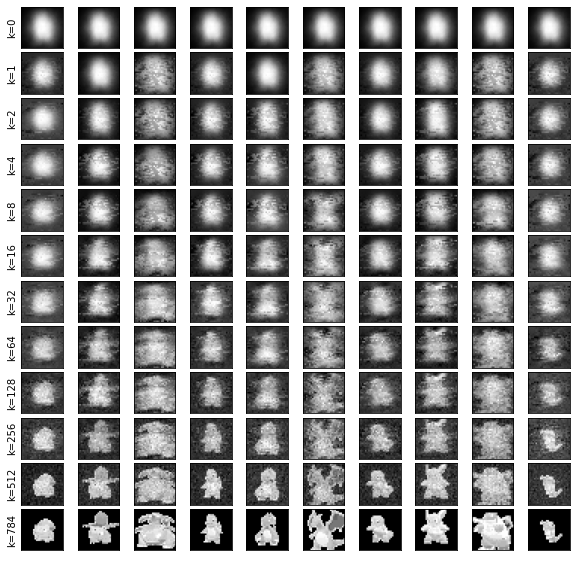

In [18]:
# Plot reconstructions at different k values.
k_values = [0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 784]

fig, ax = plt.subplots(len(k_values), 10, figsize=(10, 10),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))

for j,k in enumerate(k_values):
  projected = X.dot(eigenvectors[:,:k]).dot(eigenvectors[:,:k].T) + mu
  for i in range(10):
    ax[j, i].imshow(projected[i].reshape(output_size,output_size), cmap='binary_r')
  ax[j, 0].set_ylabel(f'k={k}');